In [1]:
%matplotlib inline

In [1]:
import sys
sys.path.append("../")

from haxml.prediction import (
    generate_rows_edwin,
    predict_xg_edwin
)
from haxml.utils import (
    get_stadiums,
    get_matches_metadata,
    load_match,
    train_test_split_matches_even_count,
    get_positions_at_time
)

from haxml.viz import (
    plot_positions,
    get_xg_time_series,
    plot_xg_time_series,
    zoom_stadium,
    plot_positions
)

from haxml.evaluation import (
    make_df
)
import pandas as pd
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import joblib
import numpy as np

In [2]:
stadiums = get_stadiums("../data/stadiums.json")
metadata = get_matches_metadata("../data/matches_metadata.csv")
clf = joblib.load("../models/random_forest_max_depth_12.pkl")
train, test = train_test_split_matches_even_count(metadata)

In [3]:
d_train = make_df(train, stadiums, generate_rows_edwin, progress=True)
d_test = make_df(test, stadiums, generate_rows_edwin, progress=True)

100%|██████████| 1235/1235 [04:32<00:00,  4.53it/s]


In [4]:
MATCH = "-MPG8aVg406bTT1daesR"
STADIUM = "NAFL 1v1/2v2 Map v1"
model_name = "random forest"
s = stadiums[STADIUM]
match = load_match(
    "../data/packed_matches/{}.json".format(MATCH),
    lambda m: predict_xg_edwin(m, s, generate_rows_edwin, clf)
)

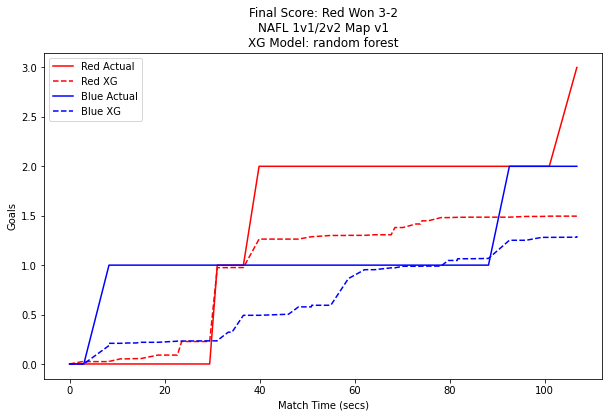

In [5]:
fig, ax = plot_xg_time_series(match)
ax.set_title("{}\nXG Model: {}".format(ax.title.get_text(), model_name))
fig.set_size_inches(10, 6)
fig

In [6]:
pd.DataFrame(match["kicks"]).query("type == 'goal'")

,time,type,fromId,fromX,fromY,fromName,fromTeam,toId,toX,toY,toName,toTeam,xg
2,8.3,goal,3,221.0,42.0,Player 8,blue,NaN,NaN,NaN,None,None,0.184873
16,31.1,goal,1,318.0,38.0,Player 7,red,NaN,NaN,NaN,None,None,0.747330
21,39.9,goal,1,-183.0,132.0,Player 7,red,NaN,NaN,NaN,None,None,0.287769
45,92.6,goal,3,-50.0,-64.0,Player 8,blue,NaN,NaN,NaN,None,None,0.183766


In [7]:
max(pd.DataFrame(match["kicks"])['xg'])

0.7473302813376006

In [8]:
kick = list(filter(lambda k: k["type"] == "goal",match["kicks"]))[0]
kick

{'time': 8.3,
 'type': 'goal',
 'fromId': 3,
 'fromX': 221.0,
 'fromY': 42.0,
 'fromName': 'Player 8',
 'fromTeam': 'blue',
 'toId': None,
 'toX': None,
 'toY': None,
 'toName': None,
 'toTeam': None,
 'xg': 0.1848733418127417}

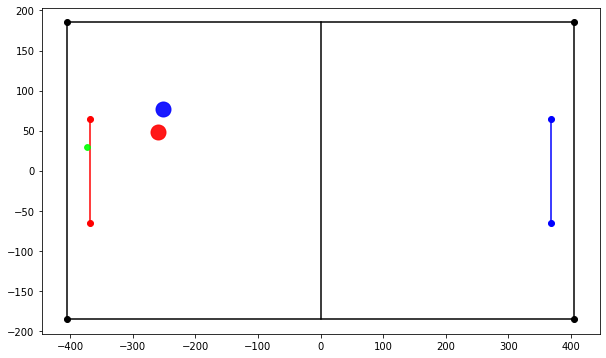

In [9]:
positions = get_positions_at_time(match["positions"], kick["time"])
fig,ax = plot_positions(positions,s)
fig.set_size_inches(10,6)
fig

In [10]:
metadata[45]

{'match_id': '-MPGtURjaUui1pTiI8nW',
 'stadium': 'NAFL 1v1/2v2 Map v1',
 'time': 94.0,
 'kicks_red': 17,
 'kicks_blue': 14,
 'score_red': 3,
 'score_blue': 2,
 'scored_goals_red': 2,
 'scored_goals_blue': 2}

Feature ranking:
1. feature 0 (0.382869)
2. feature 7 (0.260271)
3. feature 1 (0.168873)
4. feature 2 (0.122164)
5. feature 4 (0.025859)
6. feature 3 (0.017055)
7. feature 6 (0.013539)
8. feature 5 (0.009369)


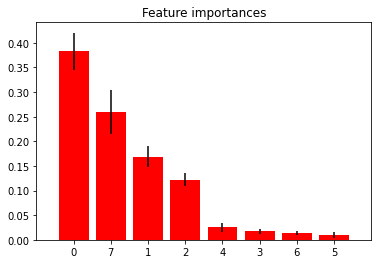

In [11]:
features = ["goal_distance","goal_angle","defender_dist","closest_defender","defenders_within_box","in_box","in_shot","ball_speed"]
X_train = d_train[features]
y_train = d_train["ag"]

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Text(0.5, 1.0, 'Feature importances')

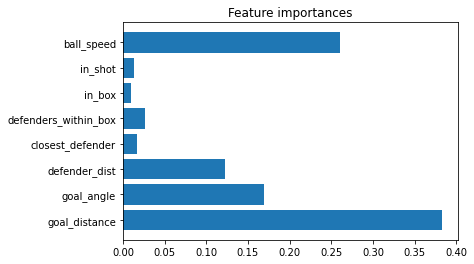

In [13]:
plt.barh(features, clf.feature_importances_)
plt.title("Feature importances")

<BarContainer object of 8 artists>

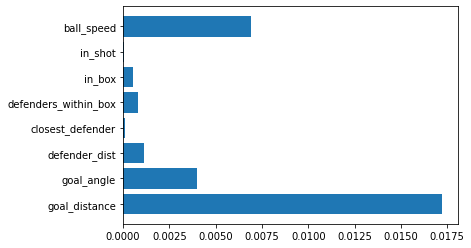

In [14]:
from sklearn.inspection import permutation_importance
X_test = d_test[features]
y_test = d_test["ag"]
perm_importance = permutation_importance(clf, X_test, y_test)
plt.barh(features, perm_importance.importances_mean)

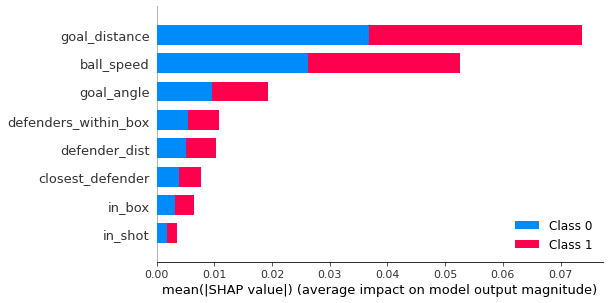

In [15]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

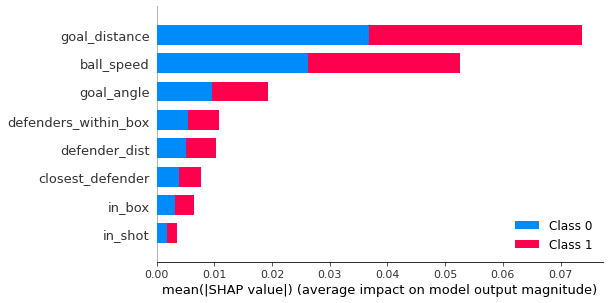

In [16]:
shap.summary_plot(shap_values, X_test)